In [1]:
%pylab
# %matplotlib inline

import pickle
import wfg
from scipy.spatial import distance_matrix
%matplotlib qt

Using matplotlib backend: Qt5Agg
Populating the interactive namespace from numpy and matplotlib


In [2]:
def find_neighbours(pool, p, thresh, show_dist=False):
    D = distance_matrix(pool, p)
    pool_nn = np.min(D, axis=1)
    assert pool_nn.shape[0] == pool.shape[0]
    
    if show_dist:
        plt.hist(pool_nn, int(S.shape[0]/2));
        plt.title('Attainment front->Pareto front nn distances');
        plt.axvline(thresh, c="C3", linestyle='--')
        
    api = pool_nn<thresh
    return api

In [3]:
def notDominated(X):
    """
    Return a Boolean vector with as many rows as X indicating whether each
    row of X is not dominated by the other elements of X; ie, whether each
    row is Pareto optimal for X.
    """
    y = zeros(X.shape[0], dtype='bool')
    for n in range(X.shape[0]):
        # Find the number of times on each row where X[i,j] >= X[n,j];
        # y[n] is not dominated if this is bigger than for every row
        y[n] = min(sum(X >= X[n,:], 1)) > 0
    return y

In [4]:
def weak_dominates(Y, x):
    """
    Test whether rows of Y weakly dominate x
    
    Parameters
    ----------
    Y : array_like
        Array of points to be tested. 
        
    x : array_like
        Vector to be tested
        
    Returns
    -------
    c : ndarray (Bool)
        1d-array.  The ith element is True if Y[i] weakly dominates x
    """
    return (Y <= x ).sum(axis=1) == Y.shape[1]


def attainment_sample(Y, Nsamples=1000):
    """
    Return samples from the attainment surface defined by the mutually non-dominating set Y

    Parameters
    ---------
    Y : array_like
        The surface to be sampled. Each row of Y is vector, that is mutually
        with all the other rows of Y
    Nsamples : int
        Number of samples

    Returns
    -------
    S : ndarray
        Array of samples from the attainment surface.
        Shape; Nsamples by Y.shape[1] 
    
    Notes
    -----
    See "Dominance-based multi-objective simulated annealing"
    Kevin Smith, Richard Everson, Jonathan Fieldsend, 
    Chris Murphy, Rashmi Misra.
    IEEE Transactions on Evolutionary Computing. 
    Volume: 12, Issue: 3, June 2008.
    https://ieeexplore.ieee.org/abstract/document/4358782
    """
    N, D = Y.shape
    Ymin = Y.min(axis=0)
    r = Y.max(axis=0) - Ymin
    S = np.zeros((Nsamples, D))
    
    # Set up arrays of the points sorted according to each coordinate.
    Ys = np.zeros((N, D))
    for d in range(D):
        Ys[:,d] = np.sort(Y[:,d])

    for n in range(Nsamples):
        v = np.random.rand(D)*r + Ymin
        m = np.random.randint(D)

        # Bisection search to find the smallest v[m] 
        # so that v is weakly dominated by an element of Y
        lo, hi = 0, N
        while lo < hi:
            mid = (lo+hi)//2
            v[m] = Ys[mid,m]
            if not any(weak_dominates(Y, v)):
                lo = mid+1
            else:
                hi = mid
        if lo == N: lo -= 1
        v[m] = Ys[lo, m]      
        assert lo == N-1 or any(weak_dominates(Y, v))
        S[n,:] = v[:]
    return S


## WFG2 Problem

In [5]:
N = 1500
M = 3                                   # Number of objectives
kfactor = 2
lfactor = 2

k = kfactor*(M-1)
l = lfactor*2

func = wfg.WFG2

# commented out to keep consistent random results.
# unable to set seed. 
f = np.zeros((N, M))
zs = np.zeros((N, k+l))
for n in range(N):
    z = wfg.random_soln(k, l, func.__name__, seed=0)
    zs[n,:] = z
    f[n,:] = func(z, k, M)

#with open('./random_zs.pkl', 'wb') as outfile:
#    pickle.dump(zs, outfile)
#with open('./random_f.pkl', 'wb') as outfile:
#    pickle.dump(f, outfile)
# with open('./random_zs.pkl', 'rb') as infile:
#     zs = pickle.load(infile)
# with open('./random_f.pkl', 'rb') as infile:
#     f = pickle.load(infile)
    
pi = notDominated(f)
di = np.invert(pi)

## Before filling

In [6]:
S = attainment_sample(f[pi], 2000)

In [29]:
fig = plt.figure(figsize=[16, 5])
ax0 = fig.add_subplot(1,3,1, projection='3d')
ax1 = fig.add_subplot(1,3,2, projection='3d')
ax2 = fig.add_subplot(1,3,3, projection='3d')
ax0.plot(*f.T, '.',  ms="3", label="samples")
ax1.plot(*f[pi].T, '.',  ms="3", c="C3", label="non-dominated")
# ax1.plot(*f[di].T, '.',  ms="3", c="lightgrey", label="dominated")
ax2.plot(*S.T, '.',  ms="3", c="C2", label="uniform attainment front samples")
# ax2.plot(*f[di].T, '.',  ms="3", c="lightgrey", label="dominated")

angle = 20
ax0.view_init(30, angle)
ax1.view_init(30, angle)
ax2.view_init(30, angle)
ax0.legend()
ax1.legend()
ax2.legend()

ax0.set_title("All points")
ax1.set_title("Dominated points")
ax2.set_title("Attainment front samples")

Text(0.5, 0.92, 'Attainment front samples')

In [18]:
api = find_neighbours(S, f[pi], 0.10, True)

In [30]:
fig = plt.figure(figsize=[8, 8])
ax = fig.gca(projection='3d')
ax.scatter(*S[np.invert(api)].T, c='lightgrey', s=4)
ax.scatter(*S[api].T, c='C3', s=4)

## Infill gaps: proof of concept

In [21]:
i1 = 29
i2 = i1+1
p1 = f[pi][np.argsort(f[pi][:,0])][i1]
p2 = f[pi][np.argsort(f[pi][:,0])][i2]

i3 = 109
i4 = i3+1
p3 = f[pi][np.argsort(f[pi][:,0])][i3]
p4 = f[pi][np.argsort(f[pi][:,0])][i4]

In [22]:
# get x values for gap points
xp1 = zs[pi][np.argsort(f[pi][:,0])][i1]
xp2 = zs[pi][np.argsort(f[pi][:,0])][i2]
xp3 = zs[pi][np.argsort(f[pi][:,0])][i3]
xp4 = zs[pi][np.argsort(f[pi][:,0])][i4]

np.testing.assert_array_almost_equal(func(xp1, k, M), p1)
np.testing.assert_array_almost_equal(func(xp2, k, M), p2)
np.testing.assert_array_almost_equal(func(xp3, k, M), p3)
np.testing.assert_array_almost_equal(func(xp4, k, M), p4)

In [25]:
fig = plt.figure(figsize=[21, 10])
ax0 = fig.add_subplot(1,1,1)
ax0.plot(*p1.T, '.',  ms="20", c="C0")
ax0.plot(*p2.T, '.',  ms="20", c="C0")
ax0.plot(*np.vstack((p1, p2)).T, c="C0", label="non-fillabel gap")
ax0.plot(*p3.T, '.',  ms="20", c="C1")
ax0.plot(*p4.T, '.',  ms="20", c="C1")
ax0.plot(*np.vstack((p3, p4)).T, c="C1", label="fillabel gap")
ax0.plot(*f[pi].T, '.',  ms="5", c="C3", label="non-dominated")
ax0.plot(*f[di].T, '.',  ms="5", c="lightgrey", label="dominated")
ax0.legend()


In [26]:
xg1 = xp1+np.subtract(xp2, xp1)/2
xg2 = xp3+np.subtract(xp4, xp3)/2

fig = plt.figure(figsize=[21, 5])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

for i in range(k+l):
    ax0.plot([i, i], [xp1[i], xp2[i]], marker='_')
    ax0.scatter([i], [xg1[i]], marker='o')
    
    ax1.plot([i, i], [xp3[i], xp4[i]], marker='_')
    ax1.scatter([i], [xg2[i]], marker='o')
    

ax0.set_title("parameter mid-points non-fillable")
ax1.set_title("parameter mid-points fillable")

Text(0.5, 1.0, 'parameter mid-points fillable')

Verifies the midpoints hace been chsen in the parameter space. 

In [14]:
yg1 = func(xg1, k, M)
yg2 = func(xg2, k, M)
assert yg1.shape == yg2.shape
yg1.shape

(2,)

Text(0.5, 1.0, 'objective mid-points fillable')

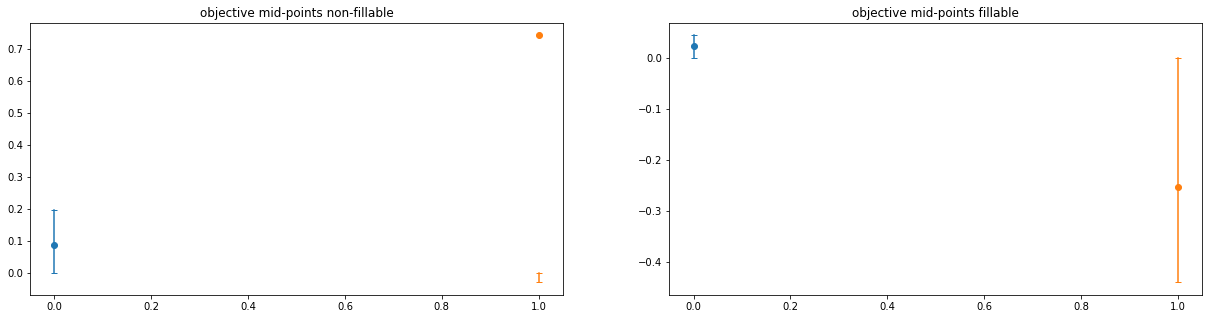

In [15]:
xg1 = (xp2+xp1)/2
xg2 = (xp4+xp3)/2

fig = plt.figure(figsize=[21, 5])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

for i in range(M):
    ax0.plot([i, i], np.array([p1[i], p2[i]])-p1[i], marker='_')
    ax0.scatter([i], [yg1[i]]-p1[i], marker='o')
    
    ax1.plot([i, i], np.array([p3[i], p4[i]])-p3[i], marker='_')
    ax1.scatter([i], [yg2[i]]-p3[i], marker='o')

ax0.set_title("objective mid-points non-fillable")
ax1.set_title("objective mid-points fillable")

    - Mid-points in the objective space are centred between the neighbors for the fillable points. 
    - One is not for the  non fillable. 

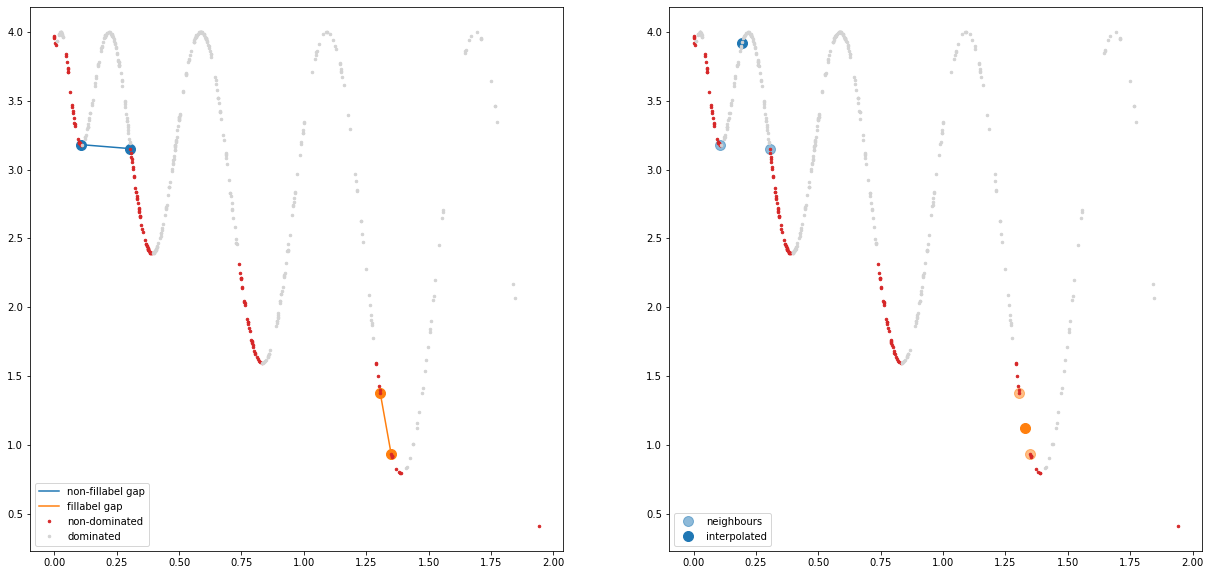

In [16]:
fig = plt.figure(figsize=[21, 10])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

ax0.plot(*p1.T, '.',  ms="20", c="C0")
ax0.plot(*p2.T, '.',  ms="20", c="C0")
ax0.plot(*np.vstack((p1, p2)).T, c="C0", label="non-fillabel gap")
ax0.plot(*p3.T, '.',  ms="20", c="C1")
ax0.plot(*p4.T, '.',  ms="20", c="C1")
ax0.plot(*np.vstack((p3, p4)).T, c="C1", label="fillabel gap")
ax0.plot(*f[pi].T, '.',  ms="5", c="C3", label="non-dominated")
ax0.plot(*f[di].T, '.',  ms="5", c="lightgrey", label="dominated")
ax0.legend()


ax1.plot(*p1.T, '.',  ms="20", c="C0", alpha=0.5, label='neighbours')
ax1.plot(*p2.T, '.',  ms="20", c="C0", alpha=0.5)
ax1.plot(*yg1.T, '.',  ms="20", c="C0", label='interpolated')
# ax1.plot(*np.vstack((p1, p2)).T, c="C0", label="non-fillabel gap")
ax1.plot(*p3.T, '.',  ms="20", c="C1", alpha=0.5)
ax1.plot(*p4.T, '.',  ms="20", c="C1", alpha=0.5)
ax1.plot(*yg2.T, '.',  ms="20", c="C1")
# ax1.plot(*np.vstack((p3, p4)).T, c="C1", label="fillabel gap")
ax1.plot(*f[pi].T, '.',  ms="5", c="C3")
ax1.plot(*f[di].T, '.',  ms="5", c="lightgrey")
ax1.legend()

## Infill gaps: process
    - find gap sizes
    - find largest gaps in f points
    - get x values
    - interp new_x
    - compute new_f
    - add to new_f to f
    - repeat n times
    - find non-dominated f points

In [17]:
# patch gaps in data with n_patches additional points. 
f_patch = f.copy()
zs_patch = zs.copy()

n_patches = 500
for i in range(n_patches):
    diffs = f_patch[np.argsort(f_patch[:,0])][1:] -f_patch[np.argsort(f_patch[:,0])][:-1]
    gaps = np.array([np.sqrt(np.dot(diff, diff.T)) for diff in diffs])
    gap_m = np.argmax(gaps)
    gapi_x = zs_patch[np.argsort(f_patch[:,0])][gap_m]
    gapj_x = zs_patch[np.argsort(f_patch[:,0])][gap_m+1]
    fill_x = (gapi_x+gapj_x)/2
    fill_y = func(fill_x, k, M)
    
    assert fill_x.shape[0] == k+l
    assert fill_y.shape[0] == M
    
    f_patch = np.vstack((f_patch, fill_y))
    zs_patch = np.vstack((zs_patch, fill_x))
    
pi_patch = notDominated(f_patch)
di_patch = np.invert(pi_patch)

assert f_patch.shape[0] == f.shape[0]+n_patches
assert zs_patch.shape[0] == zs.shape[0]+n_patches

Text(0.5, 1.0, 'After')

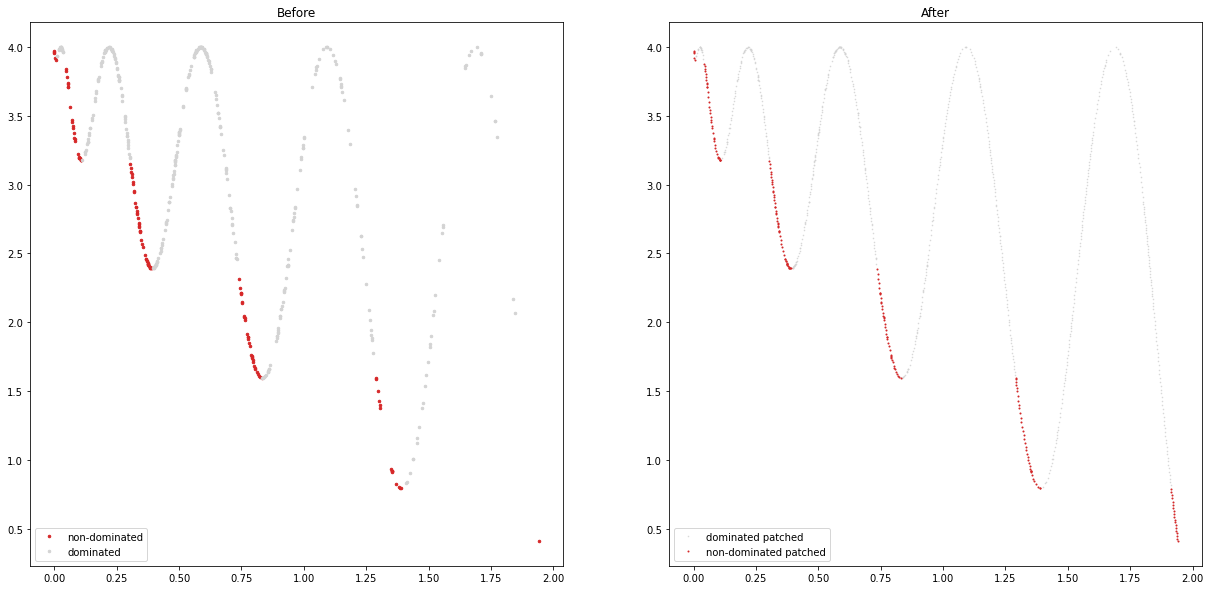

In [18]:
fig = plt.figure(figsize=[21, 10])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

ax0.plot(*f[pi].T, '.',  ms="5", c="C3", label="non-dominated")
ax0.plot(*f[di].T, '.',  ms="5", c="lightgrey", label="dominated")
ax0.legend()


ax1.plot(*f_patch[np.argsort(f_patch[:,0])].T, '.', ms=1, c="lightgrey", label="dominated patched")
# ax1.plot(*f[pi].T, 'x',  ms="7", c="C0", label="orginal non-dominated")
ax1.plot(*f_patch[pi_patch].T, '.',  ms="2", c="C3", label="non-dominated patched")
ax1.legend()

ax0.set_title("Before")
ax1.set_title("After")

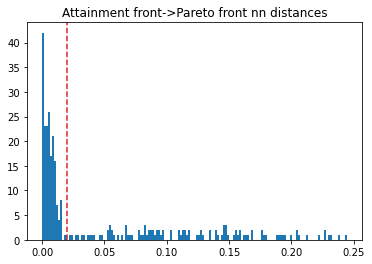

In [19]:
S_patch = attainment_sample(f_patch[pi_patch], 300)
api_patch = find_neighbours(S_patch, f_patch[pi_patch], 0.02, True)

Text(0.5, 0.98, 'Attainment front scatter chosen by proximity to Pareto')

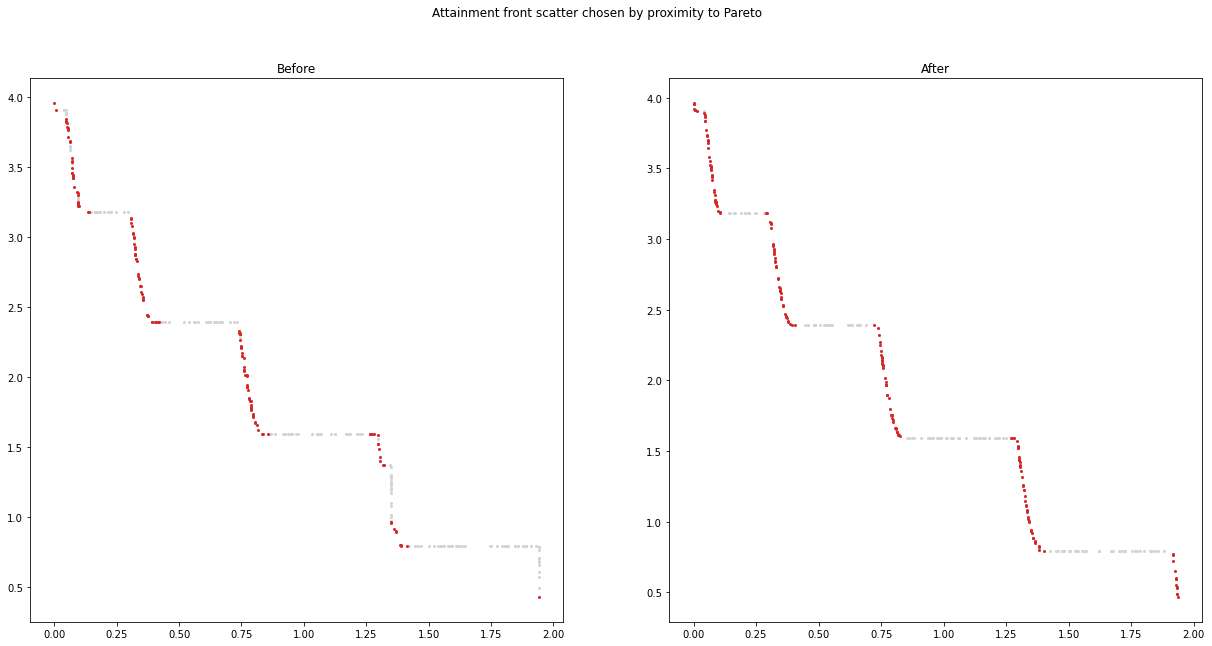

In [20]:
fig = plt.figure(figsize=[21, 10])
ax0 = fig.add_subplot(1,2,1)
ax1 = fig.add_subplot(1,2,2)

ax0.scatter(*S[np.invert(api)].T, c='lightgrey', s=4)
ax0.scatter(*S[api].T, c='C3', s=4)
ax0.set_title('Before')

ax1.scatter(*S_patch[np.invert(api_patch)].T, c='lightgrey', s=4)
ax1.scatter(*S_patch[api_patch].T, c='C3', s=4)
ax1.set_title('After')

fig.suptitle('Attainment front scatter chosen by proximity to Pareto')

## Method
    - find the nearest neighbour points
    - find the farthest nearest neighbour point

In [88]:
points = np.random.uniform(0, 1, size=(2, 3))
points.shape
midpoint = points.sum(axis=0)/2

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*points.T)
ax.scatter(*midpoint.T)

In [89]:
points = np.random.uniform(0, 1, size=(500, 3))
points.shape

fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*points.T)

In [90]:
from scipy.spatial import distance_matrix

In [96]:
D = distance_matrix(points, points)
np.fill_diagonal(D, np.nan)
plt.imshow(D)

In [146]:
def get_min_inds(D):
    a = np.nanargmin(D)
    ind0 = a%len(D)
    ind1 = a//len(D)
    return ind0, ind1

def get_max_inds(D):
    nn = np.nanmin(D, axis=0)
    i = np.nanargmax(nn)
    j = np.nanargmin(D[i]-v)
    return i, j

In [ ]:
points_ = points.copy()
for i in range(5000):
    Di = distance_matrix(points_, points_)
    np.fill_diagonal(Di, np.nan)
    ai, aj = get_min_inds(Di)
    bi, bj = get_max_inds(Di)
    new_p = (points_[bi]+points_[bj])/2
    points_[ai] = new_p

In [153]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*points[ai].T, s=25, c="C1")
ax.scatter(*points[aj].T, s=25, c="C1")
ax.scatter(*points[bi].T, s=25, c="C2")
ax.scatter(*points[bj].T, s=25, c="C2")
ax.scatter(*points.T, s=5)

In [154]:
fig = plt.figure()
ax = fig.gca(projection='3d')
ax.scatter(*points_[ai].T, s=25, c="C1")
ax.scatter(*points_[aj].T, s=25, c="C1")
ax.scatter(*points_[bi].T, s=25, c="C2")
ax.scatter(*points_[bj].T, s=25, c="C2")
ax.scatter(*points_.T, s=5)

In [61]:
print(min_ind)
print(min_ind2)

1
17
